<a href="https://colab.research.google.com/github/TheGodseeker/ML_PR/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Методы кластеризации и оценка качества кластеризации

Загрузите набор данных из файла cluster datasets в соответствии с вашим вариантом (если считаете, что набор данных не представляет необходимой информации или сложен для интерперетации или, то можно выбрать другой - но **необходимо предварительное согласование**).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from statistics import median, mean, stdev
from math import erfc
from sklearn.cluster import DBSCAN
# раздробить жанры
df = pd.read_csv("/home/tengu/Загрузки/ds_salaries.csv")
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

Используйте представленные в практике методы кластеризации (помните, что кластеры строятся по классам).

Несколько правил перед выполнением задания:
0. Внимательно изучить практику 4!
1. Служебные комментарии читать внимательно и не удалять
2. Выполнить до 10-11-2023 (но не затягивать, таск не простой!)


P.S. Мгномерные данные - данные, в которых количество колонок > 3

P.S.S. Служебные комментарии - ячейки с описанием задачи в """ task description """



In [ ]:
"""
Предварительно - оптимизируйте ваш набор данных.
1. Удалить лишние колонки (порядковые признаки, с множеством пропусков, с кучей выбросов, ....)
2. Обработайте выбросы и пропуски (Для удобства - ваш коллега сделал библиотеку в pypi для анализа выбросов - подробности уточняйте в группе)
3. Скопируйте df в df_cluster # df_cluster = df.copy()
далее вы работаете с ним
4. Выполните масштабирование числовых признаков StandatdScaler || MinMaxScaler, в df_cluser замените числовые признаки на отмасштабированные
5. Для кагегориальных значений используйте LabelEncoder - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html. В df_cluster замените на encoded признаки
"""

In [ ]:

#Класс для чистки
class Burst:
  def __init__(self, df):
    self.df = df

  #Выбросы по средней
  def bursts_by_mean(self, column_name):
    mean_data = mean(self.df[column_name])
    maximum = mean_data * 2
    result = []
    col_series = self.df[column_name] # [(index, value), (index, value)]
    cur_series_size = 0

    for index, value in col_series.items():
      if abs(value) - mean_data > maximum:
        result.append(index)

    return result

  #Выбросы по критерию Шовене
  def burst_by_shovene(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    my_mean = mean(self.df[column_name])
    my_stdev = stdev(self.df[column_name])

    for index, value in col_series.items():
      if (my_stdev > 0) and erfc(abs(value-my_mean)/my_stdev) < 1 / (2*col_series.size):
          result.append(index)

    return result
  #Выбросы по квартилям
  def burst_by_quart(self, column_name):
    col_series = self.df[column_name]
    cur_series_size = 0
    result = []
    qs = col_series.quantile([0.25,0.5,0.75])

    for index, value in col_series.items():
      if (value > qs[0.75]) or (value < qs[0.25]):
        result.append(index)

    return result

  #Выбросы по двум переменным #нужно оганизовать поиск по нескольким СТОЛБЦАМ
  def burst_by_num(self, fst, scd):
    trg = self.df.loc[:, [fst, scd]].values
    # x = self.df.loc[fst]
    # y = self.df.loc[scd]

    dbscan = DBSCAN(eps = 8, min_samples = 4).fit(trg) # fitting the model
    labels = dbscan.labels_ # getting the labels

    # plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
    # plt.xlabel(fst) # X-axis label
    # plt.ylabel(scd) # Y-axis label
    # plt.show()


In [ ]:
#Убираем лишние столбцы
#df = df.drop("anime_id", axis=1)
#df = df.drop("episodes", axis=1)

df = df.drop(['job_title'], axis=1)

for i in df.columns:
  if df[i].isnull().sum() > (df.size / 3):
    df = df.drop(i, axis=1)


In [ ]:
#Удаляем пустоты и выбросы
df = df.dropna()

sel_col = ['salary', 'salary_in_usd','remote_ratio']
burster = Burst(df)
for i in sel_col:
  if i in df.columns:
    df.drop(burster.burst_by_quart(i))

In [ ]:
#Копируем данные
df_cluster = df.copy()

In [ ]:
#Масштабируем

num_features = df_cluster.select_dtypes(include=['float64','int64']).columns

from sklearn.preprocessing import StandardScaler
# Standard масштабирование
scaler_std = StandardScaler()
df_cluster[num_features] = scaler_std.fit_transform(df_cluster[num_features])
# df_std_scaled.Score.unique() # преобразованные уникальные значения в числовом призанке в диапозоне [0, 1]


In [ ]:
#Манипуляции  с кат. значениями

from sklearn.preprocessing import LabelEncoder

sel_col = ['work_year', 'experience_level', 'employment_type', 'salary_currency', 'employee_residence',
       'company_location', 'company_size']

for i in sel_col:
  cur_le = LabelEncoder()
  cur_le.fit(df_cluster[i].unique())
  df_cluster[i] = cur_le.transform(df_cluster[i].values)

df_cluster

,work_year,experience_level,employment_type,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,3,3,2,-0.164827,7,-0.820391,26,1.105918,25,0
1,3,2,0,-0.239277,19,-1.706187,75,1.105918,70,2
2,3,2,0,-0.245978,19,-1.777563,75,1.105918,70,2
3,3,3,2,-0.023371,19,0.593676,11,1.105918,12,1
4,3,3,2,-0.105266,19,-0.278686,11,1.105918,12,1
...,...,...,...,...,...,...,...,...,...,...
3750,0,3,2,0.329525,19,4.352762,75,1.105918,70,0
3751,1,2,2,-0.059107,19,0.213009,75,1.105918,70,0
3752,0,0,2,-0.127602,19,-0.516603,75,1.105918,70,2
3753,0,0,0,-0.135047,19,-0.595909,75,1.105918,70,0


In [ ]:
"""
Здесь k-means и метрики. Используйте несколько вариантов метрик (из практики), для поиска оптимального числа кластеров.
"""

In [ ]:
# Создаем экземпляр модели K-Means
X = df_cluster [["experience_level", "salary_in_usd"]]

kmeans = KMeans(n_clusters=8)

# Производим кластеризацию данных
kmeans.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_


/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
kmeans_2 = KMeans(n_clusters=16)

# Производим кластеризацию данных
kmeans_2.fit(X)

# Получаем центры кластеров и прогнозируем принадлежность к кластерам
cluster_centers_2 = kmeans_2.cluster_centers_
cluster_labels_2 = kmeans_2.labels_


/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
"""
Здесь визуализация кластеров k-means
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

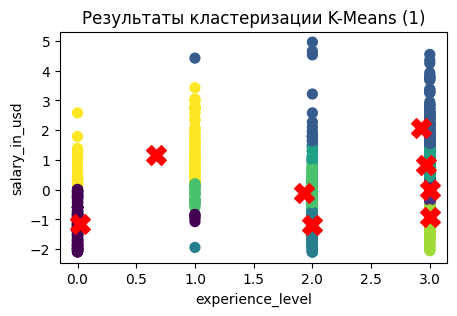

In [ ]:
# Визуализируем результаты кластеризации двумерной кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (1)')
plt.show()

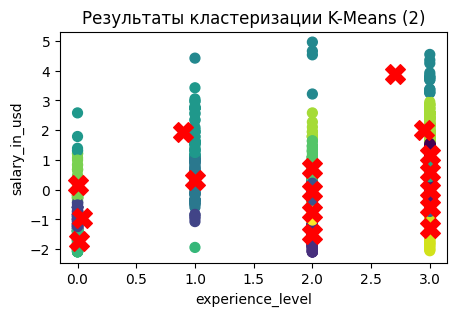

In [ ]:
# Визуализируем результаты кластеризации
plt.scatter(df_cluster["experience_level"], df_cluster["salary_in_usd"], c=cluster_labels_2, s=50, cmap='viridis')
plt.scatter(cluster_centers_2[:, 0], cluster_centers_2[:, 1], c='red', s=200, marker='X')
plt.xlabel("experience_level")
plt.ylabel("salary_in_usd")
plt.title('Результаты кластеризации K-Means (2)')
plt.show()

Оптимальное число кластеров 2, с баллом 0.8396551796866304


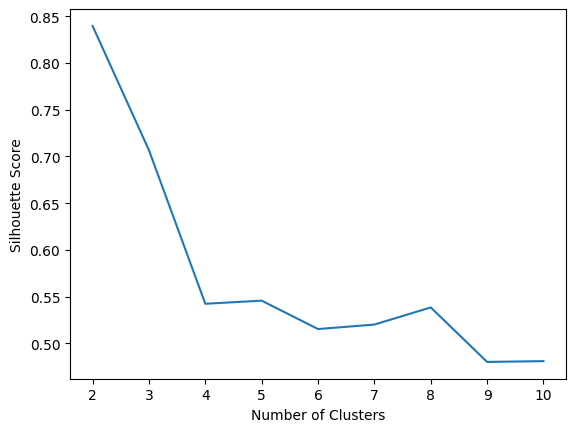

In [ ]:
# silhouette score на 16

from sklearn.metrics import silhouette_score

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального K
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")
# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Оптимальное число кластеров 10, с баллом 18522.6208473723


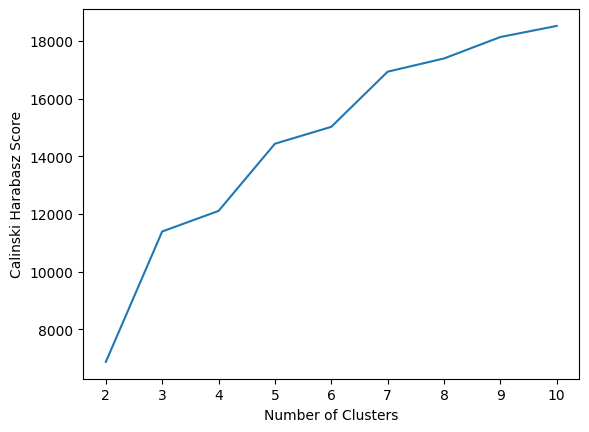

In [ ]:
#calinski_harabasz_score на 16
from sklearn.metrics import calinski_harabasz_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    scores.append(score)

print(f"Оптимальное число кластеров {scores.index(max(scores)) + 2}, с баллом {max(scores)}")

# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [ ]:
"""
Здесь DBSCAN и метрики. Используйте поиск оптимального EPS. Объясните почему?
"""

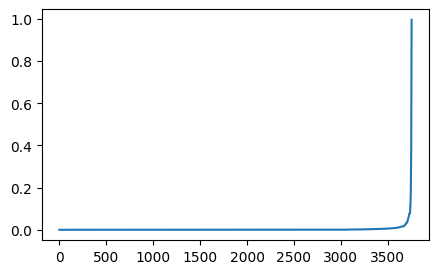

In [ ]:
#Находим eps
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

Опираясь на график, можно сказать, что eps=0.035

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

x_scaler = StandardScaler().fit_transform(X)

# Инициализация и обучение модели DBSCAN
dbscan = DBSCAN(eps=0.035, min_samples=16)
dbscan.fit(x_scaler)

# Получение меток кластеров для каждой точки (-1 означает выбросы)
labels = dbscan.labels_

In [ ]:
"""
Здесь визуализация кластеров DBSCAN
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

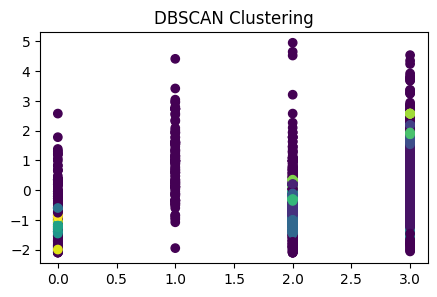

In [ ]:
# Визуализация результатов, темные точки - выбросы
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

Оптимальное число кластеров 7, с баллом 0.6277497471355711


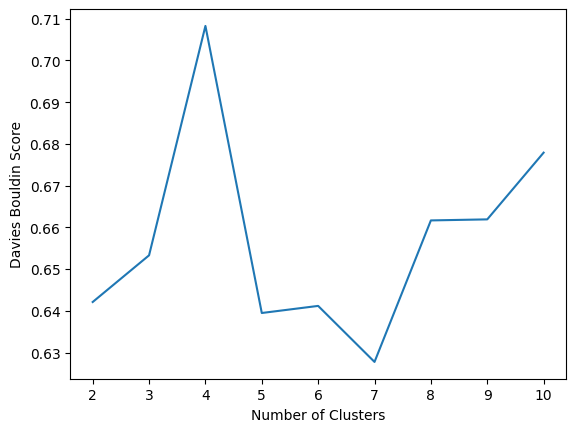

In [ ]:
from sklearn.metrics import davies_bouldin_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=16, random_state=42)
    kmeans.fit(X_scaled)
    score = davies_bouldin_score(X_scaled, kmeans.labels_)
    scores.append(score)
print(f"Оптимальное число кластеров {scores.index(min(scores)) + 2}, с баллом {min(scores)}")
# Визуализация результатов
plt.plot(range(2, 11), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

In [ ]:
"""
Здесь иерархическая кластеризация и метрики
"""

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Инициализация и обучение модели иерархической кластеризации
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit(X)

AgglomerativeClustering(n_clusters=4)

In [ ]:
"""
Здесь визуализация кластеров иерархической кластеризации
(Для многомерных данных используйте сжатие методами (на выбор один из) PCA/t-TSNE/umap до 2,3 точек - влияет на вид гарфика, если 2 точки - то двумерный, если три точки - то трехмерный)
"""

In [ ]:
# Визуализация дендрограммы
from scipy.cluster import hierarchy
linkage_matrix = hierarchy.linkage(X, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [ ]:
# Визуализация результатов кластеризации
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=agg_clustering.labels_, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.show()

In [ ]:
!pip install ydata-profiling

Выполните профилирование набора данных относительно кластеров, используя оригинальный набор данных.

P.S. задание для всех

In [ ]:
#
#### Приветсвуется ручной анилиз - гарфики, статистика по разным кластерам, как альтернативный путь решения задачи
#

# 1. в оригинальный набор данных добавьте колонки с кластерами и работаем с ним

"""
df['kmeans_cluster'] = kmeans_cluster.labels_
df['dbsscan_cluster'] = dbsscan_cluster.labels_
...
"""

# 2. Выполните фильтрацию относительно каждого кластера и каждого алгоритма (Внимание, кластер -1 не учитываем в DBSSCAN, тк это выбросы. То есть, точки не вошли ни в одни кластер)
"""
P.S за пример взять 1 тип кластеров, выполните для всех (если кластеров больше 3, разрешено использовать первые три кластера для анализа)

from ydata_profiling import ProfileReport
df['dbscan_labels'] = dbscan.labels_

uniq_labels = tuple(set(dbscan.labels_))

print(uniq_labels)

"""

# 3. Выполните профилирование
"""
На отдельной ячейке выполните профилирование для каждого кластера и каждого алгоритма

from ydata_profiling import ProfileReport

ProfileReport(df[df.dbscan_labels == 0]) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

"""

# 4. Проанализируйте результат по кластерам. Какие переменные попали в каждый кластер, их различия (статистические), графики.
# Постарайтесь объяснить различия "фактически".
# Например, видно, что в кластер 1 у пациентов возраст выше в среднем и в медиане, чем в остальных, что может свидетельствоать о влиянии возраста на кластер №()



In [ ]:
df['kmeans_cluster'] = cluster_labels_2
df['dbscan_cluster'] = labels

In [ ]:
from ydata_profiling import ProfileReport

df['dbscan_labels'] = dbscan.labels_

#df["kmeans_labels"] = cluster_labels_2
uniq_labels = tuple(set(cluster_labels_2))

print(uniq_labels)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)


In [ ]:
df.dbscan_labels.unique()

array([ 0, -1,  1,  2,  3,  4, 16,  5,  6,  7,  8,  9, 20, 11, 18, 14, 10,
       12, 13, 15, 17, 19])

In [ ]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'salary',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'kmeans_cluster',
       'dbsscan_cluster', 'dbscan_cluster', 'dbscan_labels'],
      dtype='object')

In [ ]:
df_analysis = df[["experience_level", "salary_in_usd", 'dbscan_labels']]
#df_analysis = df_analysis.dropna()
# df_analysis = df_analysis[df.dbscan_labels == 0]

In [ ]:
result = df_analysis[df.dbscan_labels == 0].drop(columns=['dbscan_labels'])

In [ ]:
ProfileReport(result)

Summarize dataset:  50%|█████     | 5/10 [00:00<00:00, 18.72it/s, scatter salary_in_usd, salary_in_usd]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 520, in _repr_html_
    self.to_notebook_iframe()
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 500, in to_notebook_iframe
    display(get_notebook_iframe(self.config, self))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/report/presentation/flavours/widget/notebook.py", line 75, in get_notebook_iframe
    output = get_notebook_iframe_srcd

In [ ]:
#нихера не работает, нужно обозревать каждый кластер вручную

from ydata_profiling import ProfileReport

ProfileReport(df_analysis[df.dbscan_labels == 0].drop(columns=['dbscan_labels'])) # фильтруем по кластерам из uniq_labels, получаем красивый результат :)

Summarize dataset:  50%|█████     | 5/10 [00:00<00:00, 12.97it/s, scatter salary_in_usd, salary_in_usd]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 520, in _repr_html_
    self.to_notebook_iframe()
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 500, in to_notebook_iframe
    display(get_notebook_iframe(self.config, self))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tengu/miniconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/report/presentation/flavours/widget/notebook.py", line 75, in get_notebook_iframe
    output = get_notebook_iframe_srcd

In [ ]:
df.dbscan_labels

0       0
1      -1
2      -1
3       0
4       0
       ..
3750   -1
3751    1
3752   -1
3753    7
3754    0
Name: dbscan_labels, Length: 3755, dtype: int64